## Week 11 Lecture 2

We have studied two approaches to extending liner models. We have added independent variables by

- taking polynomial transformations involving products of features or
- applying one-hot encoding to categorical data 

We want to study a third approach

- transforming independent variables and dependent variables with logarithms

We will take another look at the text in the novel Huckleberry Finn. Remember that we can relate frequency and rank of words with a linear relationship following a logarithmic transformation. 

We want to add features to models to improve the predictions. However with more features, we will have more parameters. We may not be able to solve for all of the parameters. Instead we will make a guess, check the guess and try to improve the guess over many iterations. The process involves a procedure called gradient descent. 

In [1]:
# Importing packages

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)

import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

### Logarithmic Transformation

Remember that we studied the association between rank and frequency of words in novels. By treating text as data, we could investigate patterns in the text of Huckleberry Finn by Mark Twain.  

In [2]:
huck_finn = pd.read_csv("huck_finn_counts.csv")
huck_finn

,rank,word,frequency
0,1,and,0.127928
1,2,the,0.098413
2,3,I,0.064505
3,4,a,0.061768
4,5,to,0.061386
...,...,...,...
45,46,get,0.007023
46,47,didn't,0.006748
47,48,says:,0.006599
48,49,what,0.006578


We counted the occurrence of the words in novel. Based on the number of occurrences, we could compute rank and frequency 

- frequency was the number of occurrences of the word divided by the total number of words in the novel 
- rank was the position of the word in sorted order from most commonly occurring to least commonly occuring

We can compute the correlation between rank and frequency.

In [3]:
huck_finn.corr()

,rank,frequency
rank,1.000000,-0.694268
frequency,-0.694268,1.000000


We find a negative correlation between rank and frequency. However the plot does not suggest a linear relationship between the variables.

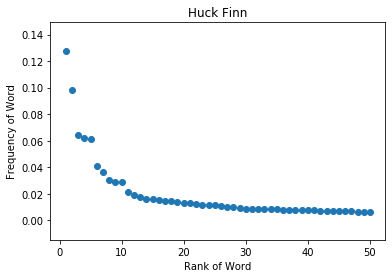

In [4]:
plt.scatter(huck_finn["rank"], huck_finn['frequency'])
plt.xlabel('Rank of Word');
plt.ylabel('Frequency of Word');
plt.title("Huck Finn")
plt.show();

We seem to have different scales among the dependent variable ranging from $10^{-1}$ to $10^{-3}$. So we should apply logarithm to the frequency.

In [5]:
huck_finn["log_frequency"] = np.log(huck_finn['frequency'])
huck_finn

,rank,word,frequency,log_frequency
0,1,and,0.127928,-2.056286
1,2,the,0.098413,-2.318584
2,3,I,0.064505,-2.741010
3,4,a,0.061768,-2.784371
4,5,to,0.061386,-2.790573
...,...,...,...,...
45,46,get,0.007023,-4.958504
46,47,didn't,0.006748,-4.998571
47,48,says:,0.006599,-5.020830
48,49,what,0.006578,-5.024050


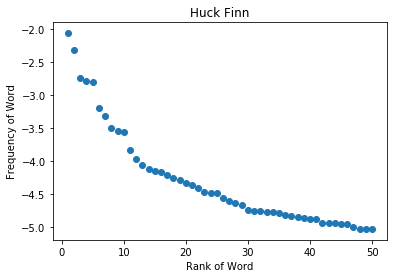

In [6]:
plt.scatter(huck_finn["rank"], huck_finn['log_frequency'])
plt.xlabel('Rank of Word');
plt.ylabel('Frequency of Word');
plt.title("Huck Finn")
plt.show();

Again we can compute the correlation

In [7]:
huck_finn.corr()

,rank,frequency,log_frequency
rank,1.000000,-0.694268,-0.902036
frequency,-0.694268,1.000000,0.918661
log_frequency,-0.902036,0.918661,1.000000


Note that the correlation has become closer to -1. However we still cannot find a linear relationship in the scatter-plot. We can try to take the logarithm of rank.  

In [8]:
huck_finn["log_rank"] = np.log(huck_finn['rank'])
huck_finn

,rank,word,frequency,log_frequency,log_rank
0,1,and,0.127928,-2.056286,0.000000
1,2,the,0.098413,-2.318584,0.693147
2,3,I,0.064505,-2.741010,1.098612
3,4,a,0.061768,-2.784371,1.386294
4,5,to,0.061386,-2.790573,1.609438
...,...,...,...,...,...
45,46,get,0.007023,-4.958504,3.828641
46,47,didn't,0.006748,-4.998571,3.850148
47,48,says:,0.006599,-5.020830,3.871201
48,49,what,0.006578,-5.024050,3.891820


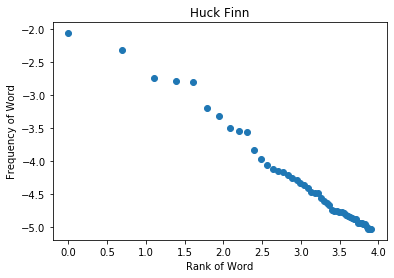

In [9]:
plt.scatter(huck_finn["log_rank"], huck_finn['log_frequency'])
plt.xlabel('Rank of Word');
plt.ylabel('Frequency of Word');
plt.title("Huck Finn")
plt.show();

We can compute the correlation. 

In [10]:
huck_finn.corr()

,rank,frequency,log_frequency,log_rank
rank,1.000000,-0.694268,-0.902036,0.908839
frequency,-0.694268,1.000000,0.918661,-0.925096
log_frequency,-0.902036,0.918661,1.000000,-0.993353
log_rank,0.908839,-0.925096,-0.993353,1.000000


Note that the correlation between logarithm of rank and logarithm of frequency is nearly -1. We should fit a linear model to the logarithmic transformation of the independent and dependent variables:

$$\text{log}(\text{Frequency}) = \text{Intercept} - \text{Slope} \times \text{log}(\text{Rank}) $$

Remember that $e$ denotes a number approximately equal to 2.71. The relationship between logarithm and exponential is   

$$e^{\log c} = c \; \text{ for any number c}$$

Moreover we have the property

$$e^{a + b} = e^a \cdot e^b$$

Therefore we can rephrase the linear model with exponents  

$$
\begin{align} 
\text{Frequency} & = e^{\operatorname{log}\left(\text{Frequency}\right)} \\
& = e^{\text{Intercept} - \text{Slope} \times \text{log}(\text{Rank}) }\\
& = e^{\text{Intercept}} \cdot e^{ - \text{Slope} \times \text{log}(\text{Rank}) }\\
& = e^{\text{Intercept}} \cdot \left(e^{ - \text{log}(\text{Rank}) }\right)^{\text{Slope}}\\
& = e^{\text{Intercept}} \cdot \left(\text{Rank}^{-1}\right)^{\text{Slope}}\\
& = \displaystyle\frac{e^{\text{Intercept}}}{\text{Rank}^{\text{Slope}}}
\end{align}
$$

Remember that we called the relationship between frequency and rank the Zipf rule. We learned that the Zipf rule is a power law. Let us use the scikit-learn package to determine the slope and intercept.

In [11]:
#first arg IV [[]] so it expects a table
#second arg is DV expects a series so []
hf_count_reg = LinearRegression().fit(huck_finn[["log_rank"]], huck_finn["log_frequency"])

In [12]:
slope = hf_count_reg.coef_[0]
slope

-0.8472346496668128

In [13]:
intercept = hf_count_reg.intercept_
intercept

-1.769698134274385

We can compute the residuals.

In [14]:
huck_finn["residuals"] = huck_finn["frequency"] - np.exp(intercept) * (huck_finn["rank"]**(slope))

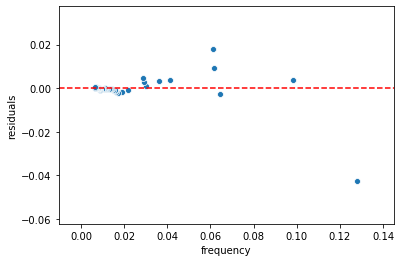

In [15]:
sns.scatterplot(huck_finn["frequency"], huck_finn["residuals"])
plt.axhline(y = 0, color = "r", linestyle="--");

With the slope and the intercept we can predict the frequency from the rank. Note that we have accurate predications for the less frequent words.

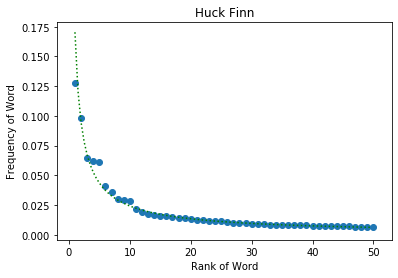

In [16]:
xvalues = np.arange(1,50,0.5)
yvalues = np.exp(intercept) * (xvalues**(slope))
plt.plot(xvalues, yvalues, "g:")

plt.scatter(huck_finn["rank"], huck_finn['frequency'])
plt.xlabel('Rank of Word');
plt.ylabel('Frequency of Word');
plt.title("Huck Finn")
plt.show();

### Gradient Descent

Remember from the study of loss functions that we used the `minimize` function in the `scipy.optimize` package to find the inputs with the smallest output. How does the `minimize` function determine the inputs? 

In [17]:
def objective_function(x):
    return (x**4 - 15*x**3 + 80*x**2 - 180*x + 144)/10

Consider `objective_function`. It has one input and one output which we can graph in a chart.

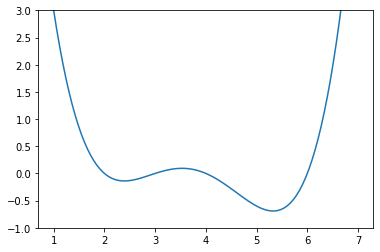

In [18]:
x = np.linspace(1, 7, 100)
plt.plot(x, objective_function(x))
plt.gca().set_ylim([-1, 3]);

We can see that the minimum is somewhere between 5 and 6. We might try to guess and check values. 

In [19]:
objective_function(5.2)

-0.6758399999999483

In [20]:
objective_function(5.3)

-0.690689999999995

In [21]:
objective_function(5.4)

-0.6854400000000282

So the minimum is around 5.3. We can generate many values and select the smallest one.

In [22]:
df_function_values = pd.DataFrame(data = {"input": np.arange(1,9,0.01), "output": objective_function(np.arange(1,9,0.01))})
df_function_values.sort_values("output")

,input,output
433,5.33,-0.691396
432,5.32,-0.691367
434,5.34,-0.691212
431,5.31,-0.691131
435,5.35,-0.690812
...,...,...
795,8.95,60.384988
796,8.96,60.901626
797,8.97,61.421433
798,8.98,61.944423


Here we are picking representative numbers within a range of inputs to guess and check the outputs. 

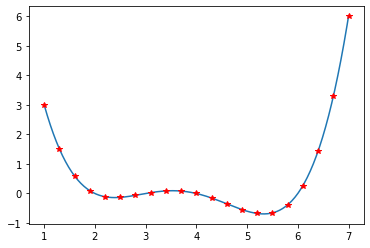

In [23]:
xs = np.linspace(1, 7, 200)
sparse_xs = np.linspace(1, 7, 21)

ys = objective_function(xs)
sparse_ys = objective_function(sparse_xs)

plt.plot(xs, ys, label = "f")
plt.plot(sparse_xs, sparse_ys, 'r*', label = "f");

Besides being inefficient, the approach might fail to find the minimum.
 - If the minimum is outside our range of guesses, the answer will be wrong.
 - Even if our range of guesses is correct, if the guesses are too coarse, our answer will be inaccurate.

Instead of choosing all of our guesses ahead of time, we can start from a single guess and try to improve on our choice. However we must decide whether to increase or decrease the guess based on the value of the function. We can use the derivative to decide between the two possibilities. 

- If the derivative of the function is negative, that means the function is decreasing, so we should go to the right (i.e. pick a bigger x). - If the derivative of the function is positive, that means the function is increasing, so we should go to the left (i.e. pick a smaller x).

So the derivative tells us which way to go.

In [24]:
def derivative_objective_function(x):
    return (4*x**3 - 45*x**2 + 160*x - 180)/10

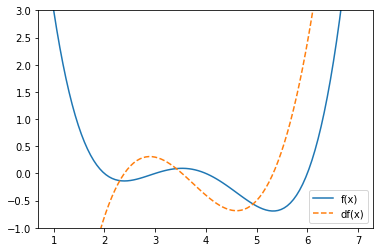

In [25]:
plt.plot(x, objective_function(x))
plt.plot(x, derivative_objective_function(x), '--')
plt.legend(['f(x)', 'df(x)'])
axes = plt.gca()
axes.set_ylim([-1, 3]);

We can write some helper functions to generate graphs of the function and the derivatives.

In [26]:
def plot_function():
    x = np.linspace(1, 7, 100)
    plt.plot(x, objective_function(x))
    plt.gca().set_ylim([-1, 3]);
    
def plot_x_on_f(f, x):
    y = f(x)
    default_args = dict(zorder=3, s=200, c="g")
    plt.scatter([x], [y], **default_args)
    
def plot_x_on_f_empty(f, x):
    y = f(x)
    default_args = dict(zorder=3, s=200, c = 'none', edgecolor='green')
    plt.scatter([x], [y], **default_args)    
    
def plot_tangent_on_f(f, x, eps=1e-6):
    slope = ((f(x + eps) - f(x - eps))
             / (2 * eps))
    xs = np.arange(x - 1, x + 1, 0.05)
    ys = f(x) + slope * (xs - x)
    plt.plot(xs, ys, zorder=2, c="green", linestyle='--')    

Let's try to implement the approach starting from an initial guess of 4. We will move in the direction indicated by the derivative.

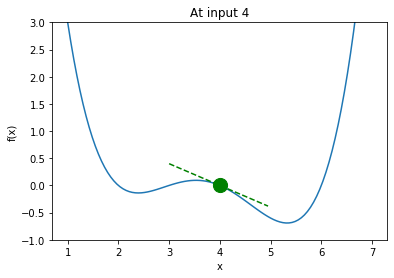

In [27]:
current_guess = 4

plot_function()
plot_x_on_f(objective_function, current_guess)
plot_tangent_on_f(objective_function, current_guess)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title("At input {}".format(current_guess));

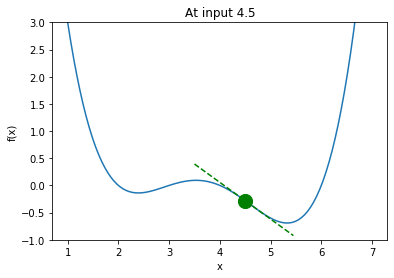

In [28]:
current_guess = 4 + 0.5

plot_function()
plot_x_on_f(objective_function, current_guess)
plot_tangent_on_f(objective_function, current_guess)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title("At input {}".format(current_guess));

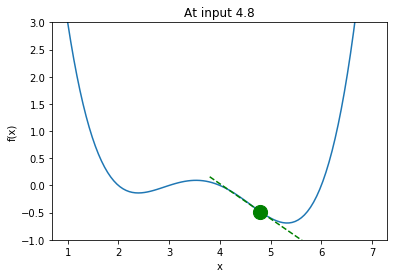

In [29]:
current_guess = 4 + 0.5 + 0.3

plot_function()
plot_x_on_f(objective_function, current_guess)
plot_tangent_on_f(objective_function, current_guess)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title("At input {}".format(current_guess));

Here we decide to move left or right depending on the value of the derivative. However, we changed the input by an arbitrary amount. Instead we should use the value of the derivative to determine the amount to change the input. 

In [30]:
def plot_one_step(x):
    new_x = x - derivative_objective_function(x)
    plot_function()
    plot_x_on_f(objective_function, new_x)
    plot_x_on_f_empty(objective_function, x)
    print(f'old x: {x}')
    print(f'new x: {new_x}')    

old x: 4
new x: 4.4


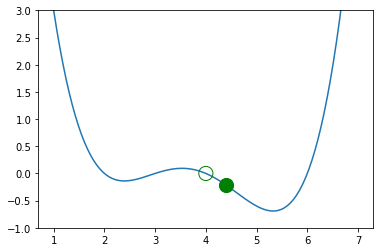

In [31]:
plot_one_step(4)

old x: 4.4
new x: 5.0464000000000055


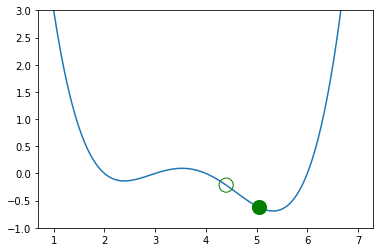

In [32]:
plot_one_step(4.4)

old x: 5.04
new x: 5.49757440000001


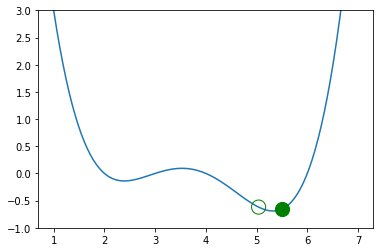

In [33]:
plot_one_step(5.04)

old x: 5.49
new x: 5.092790400000004


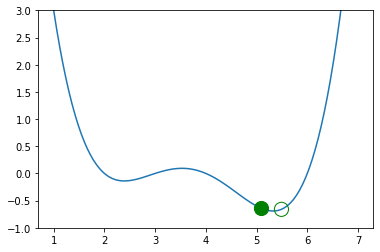

In [34]:
plot_one_step(5.49)

Note that we passed the minimum around 5.3 in going from 5.04 to 5.49. At the next iteration we turn around. However, we pass the minimum in going from 5.49 to 5.04. 

We need to make a smaller change to the input around the minimum. 

In [35]:
def plot_one_step_better(x):
    new_x = x - 0.3 * derivative_objective_function(x)
    plot_function()
    plot_x_on_f(objective_function, new_x)
    plot_x_on_f_empty(objective_function, x)
    print(f'old x: {x}')
    print(f'new x: {new_x}')    

old x: 5.49
new x: 5.370837120000001


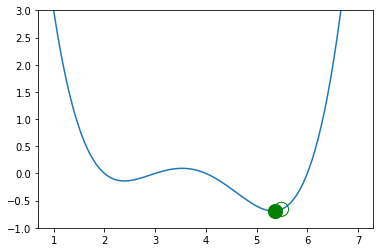

In [36]:
plot_one_step_better(5.49)

So at each iteration, we have a rule to update the input

$$
x^{(t+1)} = x^{(t)} -  0.3 \frac{d}{dx} f(x)
$$

Note that $\frac{d}{dx} f(x)$ means the derivative of the function. Remember that the derivative is just the rate of change. 

We call the procedure **gradient descent**. Note that the value $0.3$ was arbitrary. We can choose any number to control the size of the change between iterations. 

$$
x^{(t+1)} = x^{(t)} -  \alpha \frac{d}{dx} f(x)
$$

We call the number $\alpha$ the **learning rate**. 

Our choice of 0.3 above was totally arbitrary. Naturally, we can generalize by replacing it with a parameter, typically represented by $\alpha$, and often called the "learning rate".

We can also write up this procedure in code as given below:

In [37]:
def gradient_descent(df, initial_guess, alpha, maximum_iterations):
    guesses = [initial_guess]
    guess = initial_guess
    
    while len(guesses) < maximum_iterations:
        guess = guess - alpha * df(guess)
        guesses.append(guess)
    
    return np.array(guesses)

Let us try it on the function.

In [38]:
trajectory = gradient_descent(derivative_objective_function, 4, 1.5, 20)
trajectory

array([4.        , 4.6       , 5.6284    , 4.39841721, 5.36714058,
       5.23345463, 5.50301118, 4.85283564, 5.77676546, 3.72284331,
       3.96846217, 4.53018801, 5.55049763, 4.6927978 , 5.70865641,
       4.05220573, 4.7135408 , 5.72270104, 3.98700301, 4.57133193])

Below, we see a visualization of the trajectory taken by gradient descent.

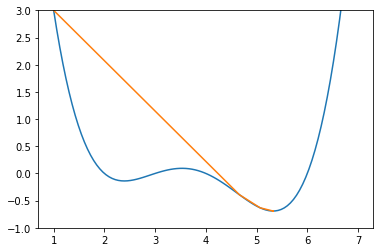

In [39]:
trajectory = gradient_descent(derivative_objective_function, 1, 0.6, 20)
plot_function()
plt.plot(trajectory, objective_function(trajectory));

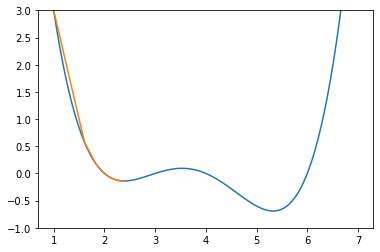

In [40]:
trajectory = gradient_descent(derivative_objective_function, 1, 0.1, 20)
plot_function()
plt.plot(trajectory, objective_function(trajectory));

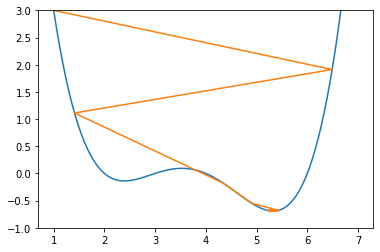

In [41]:
trajectory = gradient_descent(derivative_objective_function, 1, 0.9, 20)
plot_function()
plt.plot(trajectory, objective_function(trajectory));